# TP Méthodes des différences temporelles -- SARSA et Q-Learning

## Frozen Lake

L'environnement Frozen Lake est un monde grille incertain dans lequel on part depuis un état initial (la case la plus en haut à gauche) pour aller à un état final (la case la plus basse à droite). L'environnement est incertain car vous marchez sur un lac gelé et l'épaisseur de glace varie. Vous pouvez donc tomber dans l'eau dans certaines cases. De plus, la glace est plus glissante à certains endroits, et donc faire un pas peut vous mener plus loin que prévu... et si le vent s'en mèle...

Au lieu d'essayer d'estimer le modèle de transition, on va utiliser SARSA et Q-learning pour résoudre ce problème.

Utilisez l'environnement Frozen Lake pour implémenter SARSA et Q-learning. Utilisez d'abord l'environnement avec une grille 4x4 pour tester vos algorithmes, puis vous devriez pouvoir les utiliser pour la grille 16x16.



## FrozenLake - familiarisation avec l'environnement

Evaluez une politique aléatoire. 

# Version 4x4:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
env = gym.make("FrozenLake-v1", render_mode='rgb_array')
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")
#
# env.reset() fait commencer un nouvel épisode
# la méthode retourne l'état initial
#
state = env.reset()
nbIt=0
rew=[]
done=False
while not done:
    #
    # env.step(action) exécute une action dans l'état courant
    # la méthode retourne:
    #    • l'état suivant
    #    • la récompense immédiate
    #    • un booléen qui indique si l'épisode est terminé
    #    • le quatrième argument ne nous est pas utile (sert pour le debuggage dans certains cas)
    #
    nextState, reward, done, info, _ = env.step(np.random.randint(4))
    print("etat numero:",nextState)
    #
    # env.render donne une réprésentation de l'état.
    #
    nbIt+=1
    rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  16  états et  4  actions
etat numero: 0
etat numero: 0
etat numero: 0
etat numero: 4
etat numero: 8
etat numero: 8
etat numero: 8
etat numero: 4
etat numero: 4
etat numero: 4
etat numero: 0
etat numero: 1
etat numero: 1
etat numero: 1
etat numero: 5
Episode terminé après 15 itérations
Récompenses obtenues: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## $\epsilon$-greedy

Implémentez une fonction qui retourne une action avec la stratégie $\epsilon$-greedy:
* exploite avec une probabilité $1-\epsilon$: ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$: on choisit une action de manière uniforme sur toutes les actions.

Vous pouvez choisir différente signature pour la fonction:
soit en lui passant:
 * le paramètre $\epsilon$
 * la table `Q`
 * l'état `s` dans lequel l'action sera exécutée
 * donc l'appel aura la forme `action = epsGreedy(eps, Q, s)`

 Autre solution, vous pouvez donner seulement la valeur de $\epsilon$ et vecteur Q(s) (qui a pour dimension le nombre d'actions). L'appel aura donc la forme `action = epsGreedy(eps, q)`

*Attention* On peut imaginer le cas particulier où on trouve plusieurs occurrence de la valeur max dans le vecteur `Q(s)`. Dans ce cas, il ne faudrait pas *toujours* choisir la même action, mais plutôt choisir une des actions ex-aequo au hasard. 
Ce cas n'est peut-être pas si exotique que cela, en particulier en début d'apprentissage, quand toutes les valeurs sont nulles. Pour explorer, il est alors souhaitable de répéter le même choix!


Pour ceux peu familier avec python, regardez le petit exemple de code ci-dessous pour illustrer quelques fonctions de la bibliothèque `numpy`
- La fonction `np.random.rand()` tire une valeur de manière uniforme entre 0 et 1. 
- La fonction np.random.choice permet de choisir de manière uniforme une valeur parmi un ensemble.
- La fonction `np.argwhere(l)` permet de donner les indices où l'entrée du vecteur l est non nul. On peut donc coupler un appel de `np.argwhere` avec un test.



In [2]:
val = np.random.rand()
print(val)
val=np.zeros(10)
# on tire au sort 10 fois une valeur dans l'ensemble {1, 3, 5}
for i in range(10):
    val[i]=np.random.choice([1,3,5])
_, count = np.unique(val,return_counts=True)
print("résultat des 10 tirages:", val)
print("la proportion de chaque valeur sur ces 10 tirages est ", count/10)
indices3 = np.argwhere(val==3)
print("Les indices de la liste val où la valeur est 3 sont:", indices3)
def epsGreedy(eps, q, s):
    if np.random.uniform(0,1) < eps:
        return np.random.randint(numActions)
    else:
        return np.random.choice(np.argwhere(q[s,] == max(q[s,])).reshape(-1,))

0.4767161785064944
résultat des 10 tirages: [3. 5. 5. 1. 1. 5. 5. 3. 3. 5.]
la proportion de chaque valeur sur ces 10 tirages est  [0.2 0.3 0.5]
Les indices de la liste val où la valeur est 3 sont: [[0]
 [7]
 [8]]


## Tester une politique

Lors de l'apprentissage, il est nécessaire d'explorer, ainsi lorsqu'on analyse les performances durant l'apprentissage, il faut avoir à l'esprit qu'une partie des choix est faite au hasard. Après avoir appris, on peut faire un test en étant glouton: à chaque état, on choisit toujours l'action qui donne la plus haute valeur de `Q`.
Implémentez une méthode qui prend en paramètre un nombre d'épisodes fixé, une table `Q`, et qui exécute la politique gloutone. La méthode retourne la valeur moyenne de la somme des récompenses sur l'épisode.

In [3]:
from tqdm import tqdm
def test(Q,n):
    cumulative_reward = 0
    # run n episodes
    for i in tqdm(range(n)):
        old_state = env.reset()[0]
        finished = False
        episode_reward = 0
        # while the game is not finished
        while not finished:
            new_state, state_reward, finished, _, _ = env.step(np.argmax(Q[old_state,:]))
            episode_reward += state_reward
            old_state = new_state
        # add the reward of last episode to the total cumulative reward
        cumulative_reward += episode_reward
    return cumulative_reward/n

### SARSA

Implémentez un fonction SARSA qui prend en paramètre
 * un nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. Vous trouverez ci-dessous une fonction $plotQ$ qui génère une représentation de la table $Q$: pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 
Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

En générant le graphique, vous devriez visualiser si l'algorithme est arrivé à améliorer les performances. Vous pouvez soit tracer directement la valeur de chaque épisode. Pour avoir une courbe un peu plus lisse, vous pouvez aussi calculer une moyenne sur une fenêtre de $k$ épisodes (la fonction $runningAvg$ effectue ce travail).

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug:
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$
   * Frozen lake est une tâche épisodique, donc ici, on peut s'intéresser simplement à la somme des récompenses accumulées lors d'un épisode. Donc on peut choisir $\gamma=1$ (pas d'escompte).

In [4]:
def runningAvg(data, windowSize):
    res = np.zeros(len(data)-windowSize)
    sum=0
    for i in range(windowSize):
        sum += data[i]
    for i in range(len(data)-windowSize):
        res[i]= sum/windowSize
        sum -= data[i]
        sum += data[i+windowSize]
    return res


# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
    if (map_size==4):
        MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
        ]
    else:
        MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
        ]
    best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
    best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show()

In [5]:
def SARSA(eps, alpha, gamma, n):
    numStates = env.observation_space.n
    numActions = env.action_space.n
    q = np.zeros((numStates, numActions))
    episodes_rewards = []
    episodes_lengths = []
    # run n episodes
    for i in tqdm(range(n)):
        old_state = env.reset()[0]
        current_ep_length = 0 
        finished = False
        old_action = epsGreedy(eps,q,old_state)  
        # while the game is not finished
        while not finished:
            new_state, reward, finished, _,_ = env.step(old_action)
            new_action = epsGreedy(eps,q,new_state)
            q[old_state, old_action] = q[old_state, old_action] + alpha*(reward + gamma*q[new_state,new_action] - q[old_state, old_action])
            old_action = new_action
            old_state = new_state
            current_ep_length += 1
        # add the reward of last episode to our list of episodes' rewards
        episodes_rewards.append(np.max(q[0]))
        episodes_lengths.append(current_ep_length + 1)   
    return q, episodes_rewards, episodes_lengths

In [6]:
# on va exécuter 35000 épisodes pour chaque méthode utilisée
n_episodes = 35000
q, episodes_rewards, episodes_lengths = SARSA(0.2, 0.02, 1, n_episodes)
print("4x4 Qtable (SARSA):\n\n",q)

100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:33<00:00, 1053.07it/s]

4x4 Qtable (SARSA):

 [[0.24258642 0.23187556 0.23012198 0.23290547]
 [0.15897453 0.1484662  0.10700389 0.21435709]
 [0.19966736 0.18615868 0.18527186 0.18416081]
 [0.09934519 0.09904964 0.11281716 0.16855989]
 [0.2622448  0.17248889 0.16666202 0.14286701]
 [0.         0.         0.         0.        ]
 [0.23306098 0.1508509  0.19403208 0.06459539]
 [0.         0.         0.         0.        ]
 [0.17128646 0.24191108 0.18344064 0.32696419]
 [0.25739864 0.42509038 0.32162883 0.23925097]
 [0.44714819 0.32252198 0.37669591 0.19462368]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.28229306 0.43214139 0.56577899 0.34159263]
 [0.58397033 0.7234898  0.67338452 0.65457513]
 [0.         0.         0.         0.        ]]


                4x4 SARSA:


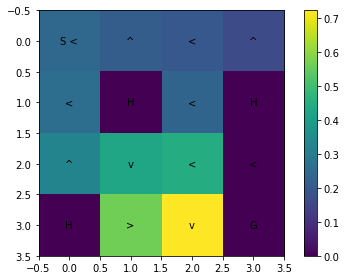

In [7]:
print("                4x4 SARSA:")
plotQ(q,4)

100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:19<00:00, 1800.35it/s]


4x4 SARSA Policy evaluation over 35000 episodes: 0.7807714285714286


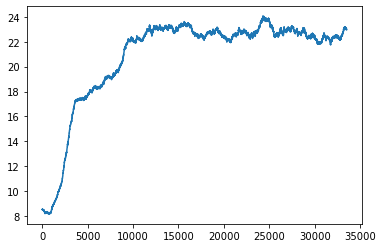

In [8]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("4x4 SARSA Policy evaluation over",n_episodes,"episodes:", test(q,n_episodes))

## Q-learning
Implémentez l'algorithme Q-learning (en partant de SARSA)



In [9]:
def Qlearning(eps, alpha, gamma, n):
    numStates = env.observation_space.n
    numActions = env.action_space.n
    q = np.zeros((numStates, numActions))
    counter = np.zeros((numStates, numActions))
    episodes_lengths = []
    # run n episodes
    for i in tqdm(range(n)):
        old_state = env.reset()[0]
        current_ep_length = 0 
        finished = False 
        # while the game is not finished
        while not finished:
            old_action = epsGreedy(eps,q,old_state) 
            new_state, reward, finished, _,_ = env.step(old_action)
            counter[old_state,old_action] += 1 
            q[old_state, old_action] = q[old_state, old_action] + alpha*(reward + gamma*np.max(q[new_state]) - q[old_state, old_action])
            current_ep_length += 1
            old_state = new_state
        # get the list containing the length (number of visited states) of each episode
        episodes_lengths.append(current_ep_length + 1)
    return q, counter, episodes_lengths

In [10]:
q, count, episodes_lengths = Qlearning(0.2, 0.02, 1, n_episodes)
print("4x4 Qtable (Q_Learning):\n\n",q)

100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:34<00:00, 1018.95it/s]

4x4 Qtable (Q_Learning):

 [[0.76827441 0.74390427 0.73751012 0.74152891]
 [0.52329872 0.44455784 0.42774298 0.68605029]
 [0.50811766 0.49577508 0.45917465 0.60790564]
 [0.21691585 0.26807816 0.18634117 0.55757756]
 [0.7661393  0.5352618  0.466161   0.52944177]
 [0.         0.         0.         0.        ]
 [0.37209205 0.23265204 0.30790654 0.2052132 ]
 [0.         0.         0.         0.        ]
 [0.44675306 0.53663617 0.52167627 0.75986772]
 [0.54380465 0.73890476 0.45270741 0.46654297]
 [0.62864255 0.54441633 0.42555464 0.39458734]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.53778369 0.62792985 0.83919098 0.57419168]
 [0.84440581 0.90929275 0.89649727 0.85973653]
 [0.         0.         0.         0.        ]]


            4x4 Q_Learning:


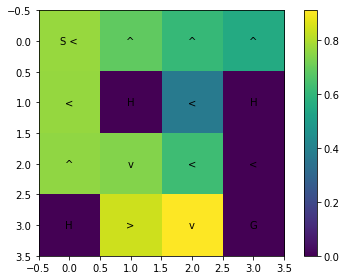

In [11]:
print("            4x4 Q_Learning:")
plotQ(q,4)

100%|██████████████████████████████████████████████████████████████████████████| 35000/35000 [00:21<00:00, 1629.26it/s]


4x4 Q_Learning Policy evaluation over 35000 episodes: 0.8248857142857143


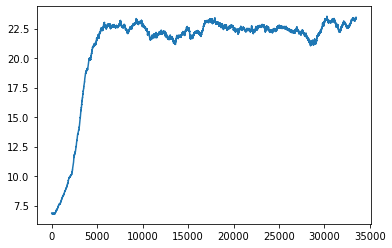

In [12]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("4x4 Q_Learning Policy evaluation over",n_episodes,"episodes:", test(q,n_episodes))

## Comparaison

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

In [13]:
def test_MC(Q,n):
    cumulative_reward = 0
    # run n episodes
    for i in tqdm(range(n)):
        old_state = env.reset()[0]
        finished = False
        episode_reward = 0
        # while the game is not finished
        while not finished:
            q_per_state = []
            for i in q:
                if i[0] == old_state:
                    q_per_state.append(q[i])
            qmax_per_state = max(q_per_state)
            maximum_action = [i[1] for i in q if q[i] == qmax_per_state and i[0] == old_state]
            new_state, state_reward, finished, _, _ = env.step(np.random.choice(maximum_action))
            episode_reward += state_reward
            old_state = new_state
        # add the reward of last episode to the total cumulative reward
        cumulative_reward += episode_reward
    return cumulative_reward/n

In [14]:
#Monte Carlo
from collections import defaultdict
def epsGreedy_MC(epsilon, q, s):
    if np.random.uniform(0,1) < epsilon:
        return np.random.choice(range(env.action_space.n))
    else:
        q_per_state = []
        for i in q:
            if i[0] == s:
                q_per_state.append(q[i])
        qmax_per_state = max(q_per_state)
        maximum_action = [i[1] for i in q if q[i] == qmax_per_state and i[0] == s]
        return np.random.choice(maximum_action)
def onPolicyMC(numEpisodes, gamma, epsilon):
    # q=0, counter=0, cumulative_gain=0 pour tous les états et toutes les actions
    q = defaultdict(lambda:0)
    # initialize q=0 for all pairs (state,action)
    for i in range(numStates):
        for j in range(numActions):
            q[i,j]=0
    counter = defaultdict(lambda:0)
    cumulative_gain = defaultdict(lambda:0)
    pi = defaultdict(lambda:None)
    episodes_lengths = []
    # iterations is the number of episodes to run
    for i in tqdm(range(numEpisodes)):
        old_state = env.reset()[0]
        visited_states = [old_state]
        state_action_reward = {}
        finished = False
        current_ep_length = 0
        # tant que le jeu n'est pas terminé
        while not finished:
            action = epsGreedy_MC(epsilon, q, old_state)
            new_state, reward, finished, _, _ = env.step(action)
            visited_states.append(new_state)
            state_action_reward[(old_state,action)] = reward
            current_ep_length += 1
            old_state = new_state
        episodes_lengths.append(current_ep_length + 1)
        # calcul de la action value q de chaque état
        state_action_totalgain = 0
        for state, action in reversed(state_action_reward):
            immediate_reward = state_action_reward[state,action]
            state_action_totalgain = immediate_reward + gamma*state_action_totalgain
            counter[state,action] += 1
            cumulative_gain[state,action] += state_action_totalgain
            # mise à jour de q dans chaque visite
            q[state,action] = cumulative_gain[state,action] / counter[state,action]
        a_star = defaultdict(lambda:None)
        for st in visited_states[:-1]:
            a_star[st] = epsGreedy_MC(epsilon, q, st)
            for a in range(numActions):
                if a == a_star[st]:
                    pi[st,a] = 1 - epsilon + epsilon/numActions
                else:
                    pi[st,a] = epsilon/numActions   
    return q, pi, episodes_lengths

In [15]:
q, pi, episodes_lengths = onPolicyMC(n_episodes, 1, 0.2)
print("4x4 Qtable (Monte Carlo On_Policy):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [00:53<00:00, 656.17it/s]

4x4 Qtable (Monte Carlo On_Policy):

 defaultdict(<function onPolicyMC.<locals>.<lambda> at 0x000001AEE1578E50>, {(0, 0): 0.19047182496027382, (0, 1): 0.1672838948604462, (0, 2): 0.17225399329520805, (0, 3): 0.17448635387917816, (1, 0): 0.10777126099706745, (1, 1): 0.10215427380125087, (1, 2): 0.08656716417910448, (1, 3): 0.15465332941061097, (2, 0): 0.13858424725822532, (2, 1): 0.11284513805522209, (2, 2): 0.10353535353535354, (2, 3): 0.11389236545682102, (3, 0): 0.07196969696969698, (3, 1): 0.052434456928838954, (3, 2): 0.04316546762589928, (3, 3): 0.05434782608695652, (4, 0): 0.20188474084813338, (4, 1): 0.14367737525632263, (4, 2): 0.1275496328528692, (4, 3): 0.12400279916025192, (5, 0): 0, (5, 1): 0, (5, 2): 0, (5, 3): 0, (6, 0): 0.13921228635125094, (6, 1): 0.08868501529051988, (6, 2): 0.12357954545454546, (6, 3): 0.023391812865497075, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (8, 0): 0.13189832837188, (8, 1): 0.1764443453044836, (8, 2): 0.16338713243422506, (8, 3): 0.239479200

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [00:46<00:00, 748.06it/s]

4x4 Monte Carlo On_Policy Policy evaluation over 35000 episodes: 0.4996285714285714


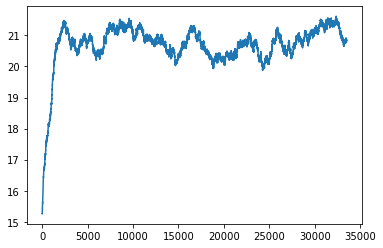

In [16]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("4x4 Monte Carlo On_Policy Policy evaluation over",n_episodes,"episodes:", test_MC(q,n_episodes))

### SARSA vs. Q_learning vs. Monte Carlo on_policy pour 4x4:

Sur 35000 épisodes, et en utilisant la grille 4x4, on remarque que l'algorithme Q_Learning a obtenu la plus grande valeur moyenne de la somme des récompenses sur l'épisode (0.824), suivi de l'algorithme SARSA (0.78), alors que Monte Carlo on_policy a obtenu 0.499 seulement.

# Version 8x8:

In [17]:
env = gym.make("FrozenLake8x8-v1",  is_slippery=True)
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")
#
# env.reset() fait commencer un nouvel épisode
# la méthode retourne l'état initial
#
state = env.reset()
nbIt=0
rew=[]
done=False
while not done:
    #
    # env.step(action) exécute une action dans l'état courant
    # la méthode retourne:
    #    • l'état suivant
    #    • la récompense immédiate
    #    • un booléen qui indique si l'épisode est terminé
    #    • le quatrième argument ne nous est pas utile (sert pour le debuggage dans certains cas)
    #
    nextState, reward, done, info, _ = env.step(np.random.randint(4))
    print("etat numero:",nextState)
    #
    # env.render donne une réprésentation de l'état.
    #
    nbIt+=1
    rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  64  états et  4  actions
etat numero: 1
etat numero: 2
etat numero: 1
etat numero: 2
etat numero: 2
etat numero: 2
etat numero: 2
etat numero: 10
etat numero: 9
etat numero: 17
etat numero: 18
etat numero: 26
etat numero: 18
etat numero: 19
Episode terminé après 14 itérations
Récompenses obtenues: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
q, episodes_rewards, episodes_lengths = SARSA(0.2, 0.02, 1, n_episodes)
print("8x8 Qtable (SARSA):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [01:56<00:00, 300.67it/s]

8x8 Qtable (SARSA):

 [[4.21915777e-01 4.24613414e-01 4.24739496e-01 4.28271847e-01]
 [4.24861004e-01 4.25160288e-01 4.26780245e-01 4.31470423e-01]
 [4.27742436e-01 4.27862324e-01 4.30116089e-01 4.37944497e-01]
 [4.31070180e-01 4.37899507e-01 4.33976875e-01 4.45297262e-01]
 [4.45071941e-01 4.54980365e-01 4.55209271e-01 4.58534978e-01]
 [4.64845900e-01 4.70442959e-01 4.78899006e-01 4.74710322e-01]
 [4.89233029e-01 4.91194507e-01 4.99052463e-01 4.94395242e-01]
 [5.04779840e-01 5.04731280e-01 5.08767394e-01 5.04865358e-01]
 [4.02200374e-01 3.86488876e-01 4.00775109e-01 4.19735723e-01]
 [3.94105562e-01 3.95856267e-01 3.89628398e-01 4.19972090e-01]
 [3.83730009e-01 3.71861104e-01 3.75894396e-01 4.17182263e-01]
 [2.80560785e-01 2.95235365e-01 2.75973495e-01 4.30073341e-01]
 [4.02843233e-01 3.78168831e-01 4.05264480e-01 4.43354362e-01]
 [4.37541069e-01 4.41560324e-01 4.51911030e-01 4.65334527e-01]
 [4.75818369e-01 4.82663717e-01 4.91909480e-01 4.87098203e-01]
 [5.04838310e-01 5.05962377e-01 5

               8x8 SARSA:


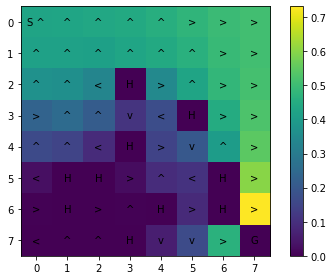

In [19]:
print("               8x8 SARSA:")
plotQ(q,8)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [01:00<00:00, 582.80it/s]


8x8 SARSA Policy evaluation over 35000 episodes: 0.9944285714285714


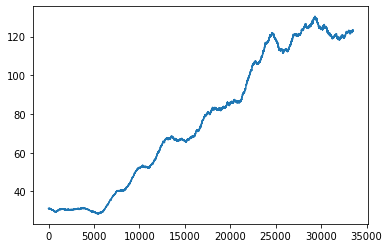

In [20]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("8x8 SARSA Policy evaluation over",n_episodes,"episodes:", test(q,n_episodes))

In [21]:
q, count, episodes_lengths = Qlearning(0.2, 0.02, 1, n_episodes)
print("8x8 Qtable (Q_Learning):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [02:55<00:00, 199.76it/s]

8x8 Qtable (Q_Learning):

 [[9.99999839e-01 9.99999853e-01 9.99999841e-01 9.99999842e-01]
 [9.99999843e-01 9.99999856e-01 9.99999844e-01 9.99999839e-01]
 [9.99999839e-01 9.99999859e-01 9.99999845e-01 9.99999846e-01]
 [9.99999838e-01 9.99999866e-01 9.99999847e-01 9.99999848e-01]
 [9.99999861e-01 9.99999862e-01 9.99999877e-01 9.99999864e-01]
 [9.99999866e-01 9.99999882e-01 9.99999873e-01 9.99999872e-01]
 [9.99999875e-01 9.99999892e-01 9.99999880e-01 9.99999875e-01]
 [9.99999899e-01 9.99999889e-01 9.99999891e-01 9.99999885e-01]
 [9.94766154e-01 9.93991012e-01 9.93830061e-01 9.99999853e-01]
 [9.86825368e-01 9.89630399e-01 9.87979983e-01 9.99999855e-01]
 [9.62723254e-01 9.63118147e-01 9.71275568e-01 9.99999860e-01]
 [6.45502379e-01 6.98534545e-01 6.93226614e-01 9.99999865e-01]
 [9.45215903e-01 9.59729272e-01 9.51179342e-01 9.99999874e-01]
 [9.81269950e-01 9.78931472e-01 9.76369247e-01 9.99999881e-01]
 [9.94766465e-01 9.93953177e-01 9.93599509e-01 9.99999894e-01]
 [9.99999892e-01 9.99999899e

            8x8 Q_Learning:


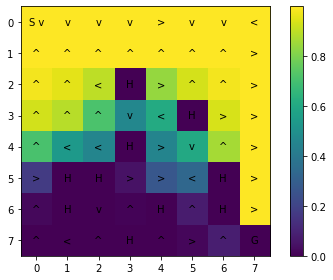

In [22]:
print("            8x8 Q_Learning:")
plotQ(q,8)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [01:30<00:00, 386.48it/s]

8x8 Q_Learning Policy evaluation over 35000 episodes: 1.0


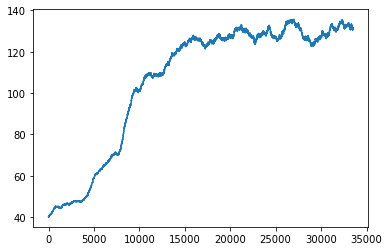

In [23]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("8x8 Q_Learning Policy evaluation over",n_episodes,"episodes:", test(q,n_episodes))

In [24]:
q, pi, episodes_lengths = onPolicyMC(n_episodes, 1, 0.2)
print("8x8 Qtable (Monte Carlo On_Policy):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [05:42<00:00, 102.26it/s]

8x8 Qtable (Monte Carlo On_Policy):

 defaultdict(<function onPolicyMC.<locals>.<lambda> at 0x000001AEE28AAAF0>, {(0, 0): 0.15097312326227988, (0, 1): 0.13329414358145344, (0, 2): 0.15345654878265505, (0, 3): 0.16516174001203943, (1, 0): 0.15404266189807128, (1, 1): 0.13393734308481606, (1, 2): 0.16293385723641127, (1, 3): 0.1652656518775762, (2, 0): 0.1625779625779626, (2, 1): 0.1629196791126077, (2, 2): 0.16617229816868712, (2, 3): 0.16447952639368524, (3, 0): 0.15767330365442003, (3, 1): 0.16943049369847438, (3, 2): 0.17816869643662608, (3, 3): 0.22592330104732655, (4, 0): 0.1714190428547607, (4, 1): 0.22604899345137036, (4, 2): 0.22402064273985456, (4, 3): 0.23405346861996237, (5, 0): 0.2342559910830392, (5, 1): 0.2651707317073171, (5, 2): 0.26960533059969244, (5, 3): 0.2547359935509875, (6, 0): 0.2717948717948718, (6, 1): 0.290239505536956, (6, 2): 0.2753483901970207, (6, 3): 0.277348616994767, (7, 0): 0.30192435301924353, (7, 1): 0.28176100628930817, (7, 2): 0.2972972972972973, (

100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [06:37<00:00, 87.95it/s]


8x8 Monte Carlo On_Policy Policy evaluation over 35000 episodes: 0.9095142857142857


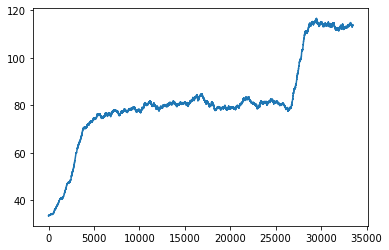

In [25]:
res = runningAvg(episodes_lengths, 1500)
plt.plot(res)
print("8x8 Monte Carlo On_Policy Policy evaluation over",n_episodes,"episodes:", test_MC(q,n_episodes))

### SARSA vs. Q_learning vs. Monte Carlo on_policy pour 8x8:

Sur 35000 épisodes, et en utilisant la grille 8x8, on remarque que l'algorithme Q_Learning a obtenu la plus grande valeur moyenne de la somme des récompenses sur l'épisode (1), suivi de l'algorithme SARSA (0.99), qui est presque le même résultat que celui de Q_learning), alors que Monte Carlo on_policy a obtenu 0.91 seulement.

## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [26]:
env = gym.make("CartPole-v1")
print("environnement avec ", env.action_space.n, " actions")
print("l'espace des états est lui codé avec une class", env.observation_space,
      " qui représente un espace continu")
print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
env.reset()
nbIt=0
done=False
while not done:
    observation, reward, done, info,_ = env.step(np.random.randint(2))
    nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 29 itérations


In [27]:
def discretise(x,mini,maxi): 
  # discretise x
  # renvoie un entier entre 0 et nval-1
    if x<mini: x=mini
    if x>maxi: x=maxi
    return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
    pos = discretise(observation[0],mini=-1,maxi=1)
    vel = discretise(observation[1],mini=-1,maxi=1)
    angle = discretise(observation[2],mini=-1,maxi=1)
    pos2 = discretise(observation[3],mini=-1,maxi=1)
    return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval

In [28]:
nval =5 # nombre de valeurs discrètes qu’une variable peut prendre
numStates= nval ** 4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
numActions = env.action_space.n
print("Le nombre d'états sera ici de ", numStates)

Le nombre d'états sera ici de  625


Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utilisé les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement! 
Avec comme paramètre $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive a atteindre un score autour de 90 pas de temps.

In [29]:
def test_2(Q,n):
    cumulative_reward = 0
    # run n episodes
    for i in tqdm(range(n)):
        old_state = encode(env.reset()[0])
        finished = False
        episode_reward = 0
        # while the game is not finished
        while not finished:
            new_state, state_reward, finished, _, _ = env.step(np.argmax(Q[old_state,:]))
            new_state = encode(new_state)
            episode_reward += state_reward 
            old_state = new_state
        # add the reward of last episode to the total cumulative reward
        cumulative_reward += episode_reward
    return cumulative_reward/n

In [30]:
def SARSA_2(eps, alpha, gamma, n, nStates):
    q = np.zeros((nStates, numActions))
    episodes_rewards = []
    episodes_lengths = []
    # run n episodes
    for i in tqdm(range(n)):
        old_state = encode(env.reset()[0])
        current_ep_length = 0 
        finished = False
        old_action = epsGreedy(eps,q,old_state)  
        # while the game is not finished
        while not finished:
            new_state, reward, finished, _,_ = env.step(old_action)
            new_state = encode(new_state)
            new_action = epsGreedy(eps,q,new_state)
            q[old_state, old_action] = q[old_state, old_action] + alpha*(reward + gamma*q[new_state,new_action] - q[old_state, old_action])
            old_action = new_action
            old_state = new_state
            current_ep_length += 1
        # add the reward of last episode to our list of episodes' rewards
        episodes_rewards.append(np.max(q[0]))
        episodes_lengths.append(current_ep_length + 1)    
    return q, episodes_rewards, episodes_lengths

In [37]:
n_episodes = 35000
q, episodes_rewards, episodes_lengths = SARSA_2(0.1, 0.1, 0.9, n_episodes, numStates)
print("Qtable (SARSA):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [01:55<00:00, 303.16it/s]

Qtable (SARSA):

 [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [38]:
res_SARSA = test_2(q,n_episodes)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [04:20<00:00, 134.35it/s]


In [33]:
def Qlearning_2(eps, alpha, gamma, n, nStates):
    q = np.zeros((nStates, numActions))
    count = np.zeros((nStates, numActions))
    episodes_lengths = []
    # run n episodes
    for i in tqdm(range(n)):
        old_state = encode(env.reset()[0])
        current_ep_length = 0 
        finished = False 
        # while the game is not finished
        while not finished:
            old_action = epsGreedy(eps,q,old_state) 
            new_state, reward, finished, _,_ = env.step(old_action)
            new_state = encode(new_state)
            count[old_state,old_action] += 1 
            q[old_state, old_action] = q[old_state, old_action] + alpha*(reward + gamma*np.max(q[new_state]) - q[old_state, old_action])
            current_ep_length += 1
            old_state = new_state
        # get the list containing the length (number of visited states) of each episode
        episodes_lengths.append(current_ep_length + 1)
    return q, count, episodes_lengths

In [34]:
q, count, episodes_lengths = Qlearning_2(0.1, 0.1, 0.9, n_episodes, numStates)
print("Qtable (Q_Learning):\n\n",q)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [04:51<00:00, 120.12it/s]

Qtable (Q_Learning):

 [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [35]:
res_QL = test_2(q,n_episodes)

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [03:14<00:00, 179.68it/s]


In [39]:
print("J'ai réussi à obtenir",res_SARSA,"et",res_QL,"en utilisant respectivement SARSA et Q_learning")

J'ai réussi à obtenir 162.0904857142857 et 118.88785714285714 en utilisant respectivement SARSA et Q_learning
